In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigvalsh, qr
from numpy import linalg as lg

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

import koala

from time import time
class Timer():
    def __init__(self, name = ""):
        self.name = name
    def __enter__(self):
        self.t0 = time()
        return self
    def __exit__(self, type, value, traceback):
        #Exception handling here
        print(f"{self.name} completed in {time() - self.t0:.2f} seconds")

Generate 30 points completed in 0.00 seconds


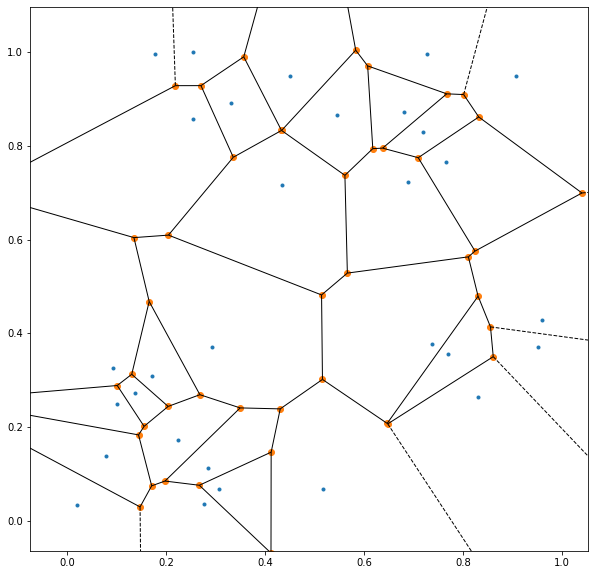

In [2]:
# create approx n points
n = 5
#n = 30 #uncomment to do a more reasonably sized lattice

with Timer(f"Generate {n} points"):
    from koala.pointsets import generate_random
    points = generate_random(n)

from scipy.spatial import Voronoi, voronoi_plot_2d
voro = Voronoi(points)
fig = voronoi_plot_2d(voro)
plt.show()

Make dual graph of 30 points completed in 0.05 seconds
Color edges of graph of 30 points completed in 0.01 seconds


<AxesSubplot:title={'center':'A full colouring'}>

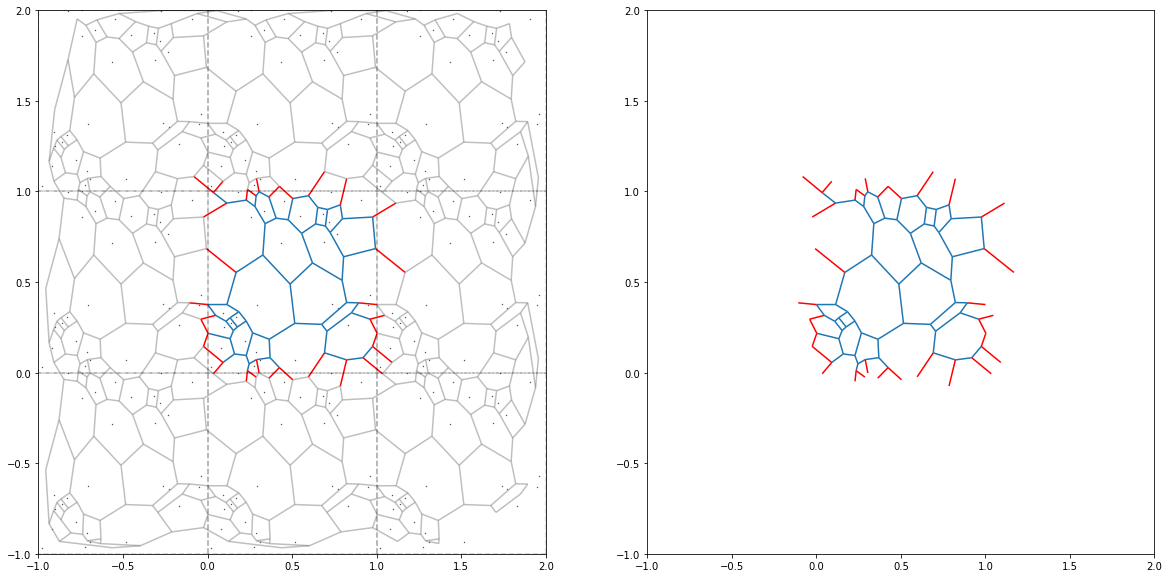

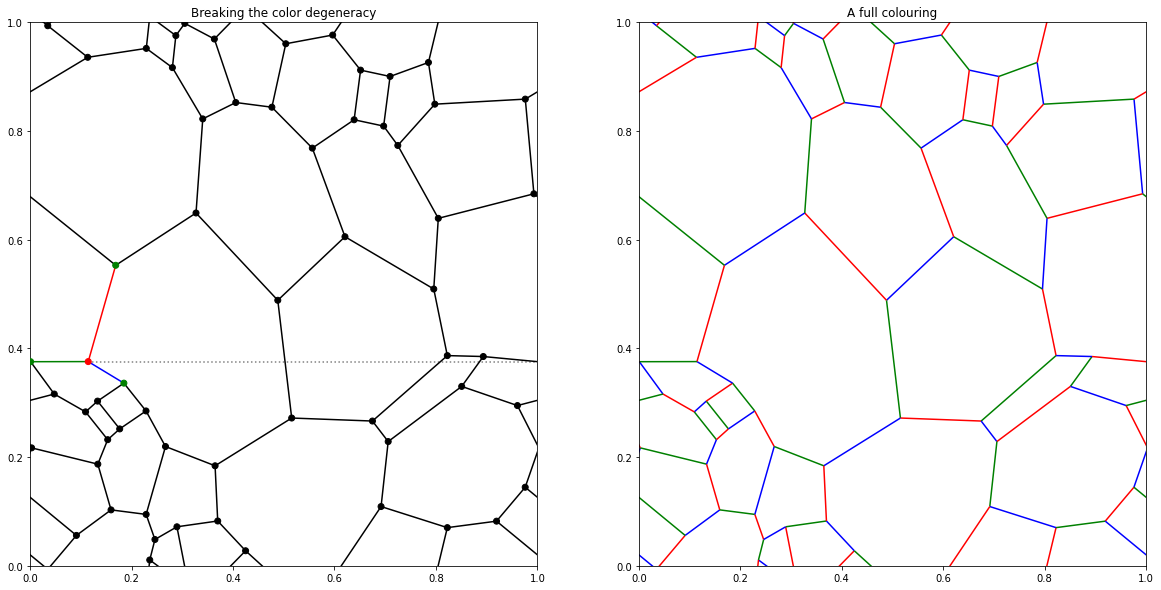

In [3]:
from koala.voronization import generate_point_array, generate_lattice
from koala.graph_utils import vertex_neighbours, clockwise_edges_about
from koala.plotting import plot_lattice, plot_degeneracy_breaking
from koala.graph_color import color_lattice, edge_color
 
with Timer(f"Make dual graph of {n} points"):
    g = generate_lattice(points, debug_plot = True)
    
#Tests
assert(np.all(np.bincount(g.edges.indices.flatten()) == 3))#all vertices have coordination number 3
    
adjacency = g.edges.indices; vertices = g.vertices.positions
fig, axes = plt.subplots(ncols = 2, figsize = (20,10))


with Timer(f"Color edges of graph of {n} points"):
    solution = color_lattice(g)
    
from koala.plotting import plot_lattice
axes[0].set(title = "Breaking the color degeneracy")
plot_degeneracy_breaking(0, g, ax = axes[0])

axes[1].set(title = "A full colouring")
plot_lattice(g, edge_labels = solution, ax = axes[1])

## Finding all the solutions for a small graph

In [4]:
with Timer(f"Generate {n} points"):
    from koala.pointsets import generate_random
    points = generate_random(min(n, 20))

#lattice
with Timer(f"Make dual graph of {n} points"):
    g = generate_lattice(points)  

fixed = enumerate(clockwise_edges_about(vertex_i = 0, g=g))

with Timer(f"Get one edge coloring"):
    solveable, solution = edge_color(g.edges.indices, n_colors = 3, fixed = fixed)
    assert(solveable)

with Timer(f"Get all unconstrained edge colorings"):
    solveable, unconstrained_solutions = edge_color(g.edges.indices, n_colors = 3, all_solutions = True)
    assert(solveable)
    
with Timer(f"Get all constrained edge colorings"):
    fixed = enumerate(clockwise_edges_about(vertex_i = 0, g=g))
    solveable, constrained_solutions = edge_color(g.edges.indices, n_colors = 3, fixed = fixed, all_solutions = True)
    assert(solveable)


degeneracy = unconstrained_solutions.shape[0] / constrained_solutions.shape[0]
assert(degeneracy == 6.0)
print(f"There are {constrained_solutions.shape[0]} solutions and the degeneracy is {degeneracy}")

Generate 30 points completed in 0.00 seconds
Make dual graph of 30 points completed in 0.13 seconds
Get one edge coloring completed in 0.01 seconds
Get all unconstrained edge colorings completed in 0.34 seconds
Get all constrained edge colorings completed in 0.03 seconds
There are 213 solutions and the degeneracy is 6.0


There are 5 solutions


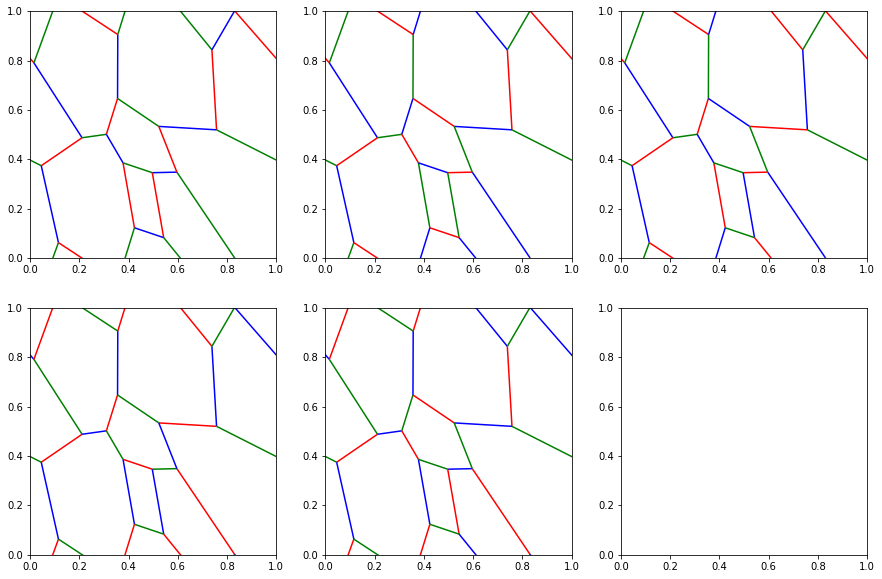

In [5]:
from math import ceil
def plot_all_solutions(g):
    fixed = enumerate(clockwise_edges_about(vertex_i = 0, g=g))
    solveable, solutions = edge_color(g.edges.indices, n_colors = 3, fixed = fixed, all_solutions = True)
    
    N = solutions.shape[0]
    size = 3
    cols, rows = min(size, N), ceil(N/size)
    fig, axes = plt.subplots(ncols = cols, nrows = rows, figsize = (5*cols, 5*rows), squeeze = False)
    print(f'There are {N} solutions')
    for ax, solution in zip(axes.flatten(), solutions):
#         plot_degeneracy_breaking(0, g, ax = ax)
        plot_lattice(g, edge_labels = solution, ax = ax)

points = generate_random(min(n,8))
g = generate_lattice(points)
plot_all_solutions(g)

3 3
There are 9 solutions


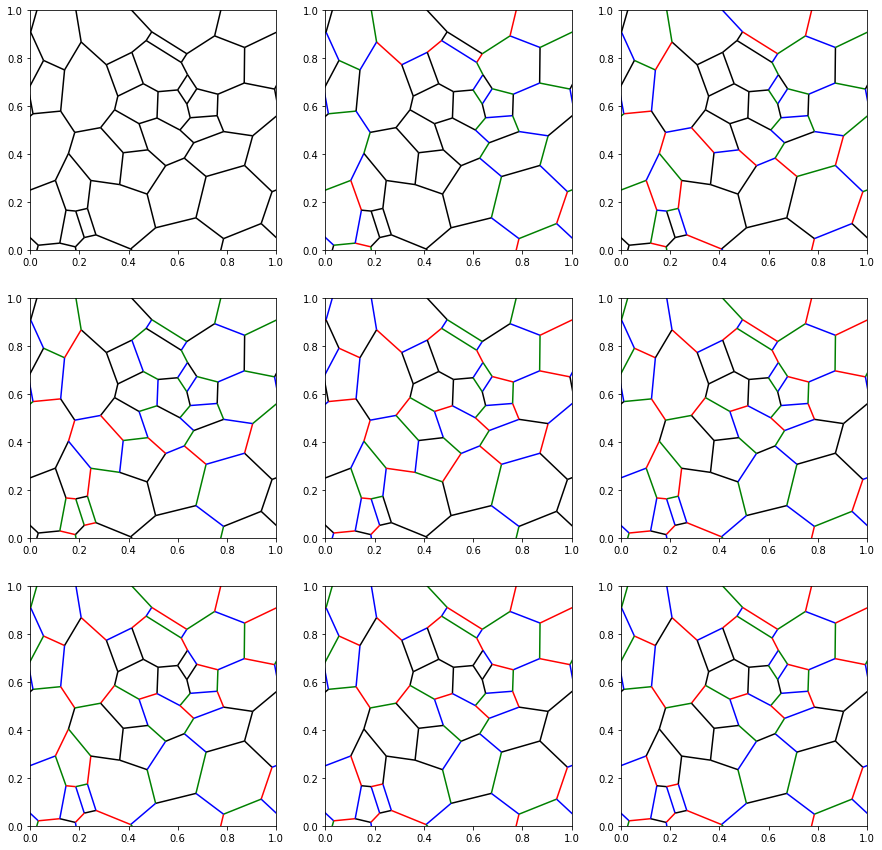

In [6]:
from math import ceil
def plot_changes(g):
    fixed = enumerate(clockwise_edges_about(vertex_i = 0, g=g))
    solveable, solutions = edge_color(g.edges.indices, n_colors = 3, fixed = fixed, n_solutions = 9)
    solutions = np.where(solutions != solutions[0,None], solutions, 3)
    
    N = solutions.shape[0]
    size = 3
    cols, rows = min(size, N), ceil(N/size)
    print(rows, cols)
    fig, axes = plt.subplots(ncols = cols, nrows = rows, figsize = (5*cols, 5*rows), squeeze = False)
    print(f'There are {N} solutions')
    for ax, solution in zip(axes.flatten(), solutions):
#         plot_degeneracy_breaking(0, g, ax = ax)
        plot_lattice(g, edge_labels = solution, ax = ax)


points = generate_random(n)
g = generate_lattice(points)
plot_changes(g)

In [7]:
n_points = n
points = generate_random(n_points)
g = generate_lattice(points)
with Timer(f"Get one edge coloring"):
    solveable, solution = edge_color(g.edges.indices, n_colors = 3, fixed = fixed)

with Timer(f"Get 100 edge colorings"):
    fixed = enumerate(clockwise_edges_about(vertex_i = 0, g=g))
    solveable, solutions = edge_color(g.edges.indices, n_colors = 3, fixed = fixed, n_solutions = 100)
    
with Timer(f"Get all edge colorings"):
    fixed = enumerate(clockwise_edges_about(vertex_i = 0, g=g))
    solveable, solutions = edge_color(g.edges.indices, n_colors = 3, fixed = fixed, all_solutions = True)

print(f"There are {solutions.shape[0]} total solutions for this graph with {n_points} points")

Get one edge coloring completed in 0.01 seconds
Get 100 edge colorings completed in 0.02 seconds
Get all edge colorings completed in 1.46 seconds
There are 3360 total solutions for this graph with 30 points
